In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip3 install gym
!pip install pyvirtualdisplay
!pip install piglet

     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 


In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (461 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 784 kB of 

In [ ]:
!pip install gym[atari]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import torchvision
import os
import gzip
import tarfile
import gc
import gym
from IPython.display import HTML
from IPython.core.ultratb import AutoFormattedTB
from pyvirtualdisplay import Display
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
print(torch.__version__)

1.4.0


I used IPython.display.HTML to view the rendered game animation on Google Colab. Unfortunately, it doesn't work when exported to .ipynb

In [ ]:
def animate_frames(frames, scale=60):
    h, w, d = frames[0].shape
    fig = plt.figure(figsize=(w/scale, h/scale))
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
    return HTML(ani.to_jshtml())

# Random play of CartPole-v0 and its animation

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
env = gym.make('CartPole-v0')
env.reset()
frames = []
for t in range(1000):
    frames.append(env.render(mode='rgb_array'))
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.render()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Episode finished after 27 timesteps


True

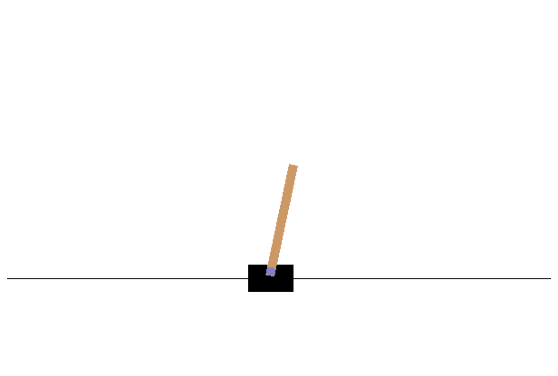

In [ ]:
animate_frames(frames, 60)

# CartPole network structure

For the network of CartPole Policy and Value functions, I used a very simple vanilla dense network.

In [ ]:
cartpole_state_dim = 4
cartpole_action_dim = 2
class CartpolePolicyNetwork(nn.Module):
  def __init__(self):
    super(CartpolePolicyNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(cartpole_state_dim, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, cartpole_action_dim)
    )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input, get_action=True):
    batch_dim, state_dim = input.shape
    input = torch.tensor(input).double()
    action_scores = self.net(input.float())
    action_probs = self.softmax(action_scores)
    if not get_action:
        return action_probs
    # Sample from the distribution if get_action=True
    actions = [np.random.choice(np.arange(cartpole_action_dim),
                                p=prob.detach().numpy())
               for prob in action_probs]
    return np.array(actions), action_probs

class CartpoleValueNetwork(nn.Module):
  def __init__(self):
    super(CartpoleValueNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(cartpole_state_dim, 10),
        nn. ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    )

  def forward(self, input):
    input = torch.tensor(input).double()
    value = self.net(input.float())
    return value

In [ ]:
policy = CartpolePolicyNetwork()

In [ ]:
state = np.array([[0,0,0,0], [1,1,1,1]])
policy(state)

(array([1, 0]), tensor([[0.4746, 0.5254],
         [0.4738, 0.5262]], grad_fn=<SoftmaxBackward>))

# CartPole training loop

In [ ]:
def generate_rollout(env, episode_length, policy):
    state = env.reset()
    experience = []
    for t in range(episode_length):
        env.render()
        action, prob = policy(state.reshape(1, len(state)))
        action = action[0]
        prob = prob[0]
        next_state, reward, done, info = env.step(action)
        experience.append([state, reward, action, prob.detach().numpy(), next_state])
        state = next_state
        if done:
            return np.array(experience)
    return np.array(experience)

def calculate_returns(rollouts, gamma):
    all_returns = []
    for r in rollouts:
        returns = [0]
        for i, s in enumerate(np.flip(r, axis=0)):
            reward = s[1]
            discounted_sum = gamma*returns[i]
            returns.append(reward + discounted_sum)
        all_returns.append(returns[1:][::-1])
    return all_returns

def likelihood(probs, actions):
    return probs[range(probs.shape[0]), actions].unsqueeze(1)

In [ ]:
exp = generate_rollout(env, 10, policy)
exps = [exp]
returns = calculate_returns(exps, 0.99)
np.column_stack([exps[0], returns[0]])

array([[array([-0.01148094, -0.00022685,  0.03894206, -0.03850274]), 1.0,
        0, array([0.4747398, 0.5252602], dtype=float32),
        array([-0.01148547, -0.19588497,  0.038172  ,  0.266208  ]),
        9.561792499119552],
       [array([-0.01148547, -0.19588497,  0.038172  ,  0.266208  ]), 1.0,
        1, array([0.47412014, 0.5258799 ], dtype=float32),
        array([-0.01540317, -0.00132802,  0.04349616, -0.01419498]),
        8.64827525163591],
       [array([-0.01540317, -0.00132802,  0.04349616, -0.01419498]), 1.0,
        1, array([0.47468907, 0.525311  ], dtype=float32),
        array([-0.01542973,  0.19314402,  0.04321226, -0.29284331]),
        7.72553055720799],
       [array([-0.01542973,  0.19314402,  0.04321226, -0.29284331]), 1.0,
        0, array([0.4749778, 0.5250222], dtype=float32),
        array([-0.01156685, -0.00256655,  0.0373554 ,  0.01314895]),
        6.793465209301],
       [array([-0.01156685, -0.00256655,  0.0373554 ,  0.01314895]), 1.0,
        1, arra

In [ ]:
class ExperienceDataset(Dataset):
    def __init__(self, experience):
        super().__init__()
        self.exp_joined = []
        for e in experience:
            self.exp_joined.extend(e.tolist())

    def __getitem__(self, index):
        return self.exp_joined[index]

    def __len__(self):
        return len(self.exp_joined)

def main():

    env = gym.make('CartPole-v0')
    policy = CartpolePolicyNetwork()
    value = CartpoleValueNetwork()

    policy_optim = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.01)
    value_optim = optim.Adam(value.parameters(), lr=1e-3, weight_decay=1)

    value_criterion = nn.MSELoss()

    # Hyperparameters
    epochs = 30
    env_samples = 100
    episode_length = 200
    gamma = 0.99
    value_epochs = 2
    policy_epochs = 5
    batch_size = 32
    policy_batch_size = 256
    epsilon = 0.2
    loop = tqdm(total=epochs, position=0, leave=False)

    policy_loss = torch.tensor([np.nan])
    avl_list = []
    apl_list = []
    ast_list = []
    for _ in range(epochs):
        # generate rollouts
        rollouts = []
        for _ in range(env_samples):
            # don't forget to reset the environment at the beginning of each episode!
            # rollout for a certain number of steps!
            experience = generate_rollout(env, episode_length, policy)
            rollouts.append(experience)

        standing_len = sum(len(experience) for experience in rollouts)
        ast = standing_len / env_samples
        #print('avg standing time:', standing_len / env_samples)
        returns = calculate_returns(rollouts, gamma)

        for i in range(env_samples):
            rollouts[i] = np.column_stack([rollouts[i], returns[i]])

        # Approximate the value function
        dataset = ExperienceDataset(rollouts)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        avl = 0
        for p in policy.parameters():
            p.requires_grad = False
        for p in value.parameters():
            p.requires_grad = True
        for _ in range(value_epochs):
            # train value network
            for states, rewards, actions, probs, next_states, returns in data_loader:
                size = len(returns)
                value_optim.zero_grad()
                baseline = value(states)
                returns = returns.float()
                value_loss = value_criterion(baseline, returns.reshape(size, 1))
                value_loss.backward()
                value_optim.step()

                avl += value_loss.item()
                loop.set_description('value loss:{:.4f}, policy loss:{:.3f}, standing time: {}'.format(value_loss.item(), policy_loss.item(), ast))

        apl = 0
        for p in policy.parameters():
            p.requires_grad = True
        for p in value.parameters():
            p.requires_grad = False
        # Learn a policy
        for _ in range(policy_epochs):
            # train policy network
            for states, rewards, actions, probs, next_states, returns in data_loader:
                size = len(returns)
                policy_optim.zero_grad()
                baseline = value(states)
                baseline = baseline.detach()

                returns = returns.float().reshape(size, 1)
                new_probs = policy(states, False)

                old_likelihood = likelihood(probs, actions)
                new_likelihood = likelihood(new_probs, actions)

                ratio = new_likelihood / old_likelihood
                advantage = returns - baseline

                l_1 = ratio * advantage
                l_2 = torch.clamp(ratio, 1-epsilon, 1+epsilon)*advantage
                policy_loss = -torch.mean(torch.min(l_1, l_2))
                policy_loss.backward()
                policy_optim.step()

                apl += policy_loss.item()
                loop.set_description('value loss:{:.4f}, policy loss:{:.3f}, standing time: {}'.format(value_loss.item(), policy_loss.item(), ast))

        avl /= (len(data_loader) * value_epochs)
        apl /= (len(data_loader) * policy_epochs)

        avl_list.append(avl)
        apl_list.append(apl)
        ast_list.append(ast)

        loop.update(1)

    return avl_list, apl_list, ast_list, policy, value

avl_list, apl_list, ast_list, policy, value = main()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
value loss:151.3551, policy loss:1.600, standing time: 196.94: 100%|██████████| 30/30 [30:00<00:00, 70.44s/it]

# Graph of the result, including the value loss, policy loss, and average standing time over the epochs

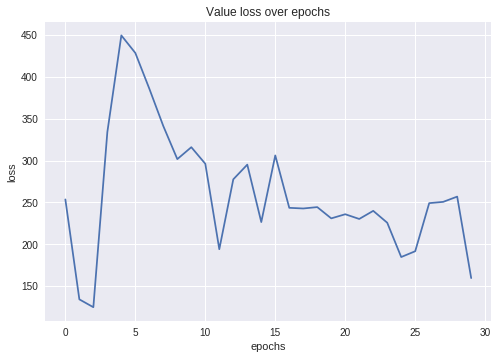

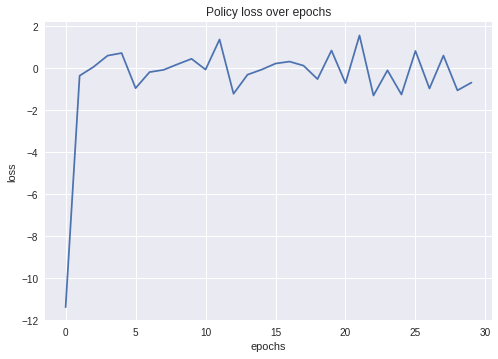

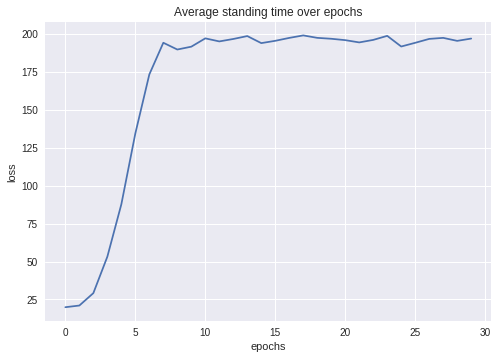

In [ ]:
fig = plt.figure()
plt.plot(avl_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Value loss over epochs")
plt.show()

plt.plot(apl_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Policy loss over epochs")
plt.show()

plt.plot(ast_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Average standing time over epochs")
plt.show()

# Demonstration of a sample run using the trained network

Can't view the animation when exported as .ipynb, but we can still see the total standing time

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
env = gym.make('CartPole-v0')
state = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(mode='rgb_array'))
    action, probs = policy(np.array([state]))
    state, reward, done, info = env.step(action[0]) # take a random action
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.render()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Episode finished after 200 timesteps


True

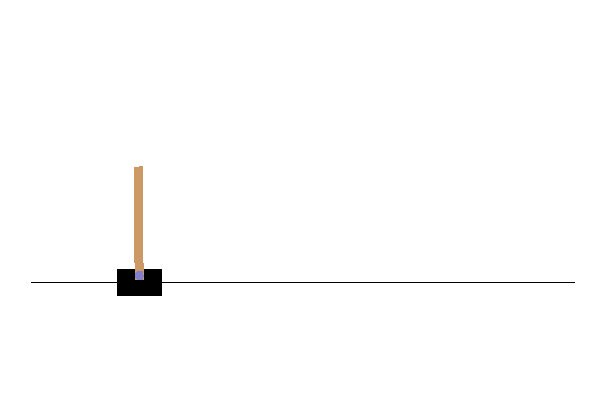

In [ ]:
animate_frames(frames, 60)

# Demonstration of learning in another domain
## Atari Assault-v0

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
env = gym.make('Assault-v0')
env.reset()
frames = []
total_reward = 0
for t in range(1000):
    frames.append(env.render(mode='rgb_array'))
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    total_reward += reward
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        print("Total reward gained", total_reward)
        break
env.render()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Episode finished after 719 timesteps
Total reward gained 357.0


True

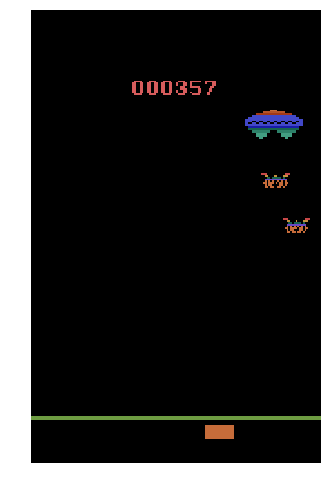

In [ ]:
animate_frames(frames, 30)

# Simple vanilla downsampling CNN for the Policy and Value networks

In [ ]:
class AssaultPolicyNetwork(nn.Module):
  def __init__(self, sigma=0.1):
    super(AssaultPolicyNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2)
    self.bn1 = nn.BatchNorm2d(16)

    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv5 = nn.Conv2d(32, 32, kernel_size=5, stride=3)
    self.conv6 = nn.Conv2d(32, 32, kernel_size=(4,2))
    self.linear = nn.Linear(32, 7)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input, get_action=True):
    d1, d2, d3, d4 = input.shape
    layer1 = self.relu(self.conv1(input))
    layer2 = self.relu(self.bn1(self.conv2(layer1)))
    layer3 = self.relu(self.conv3(layer2))
    layer4 = self.relu(self.bn2(self.conv4(layer3)))
    layer5 = self.relu(self.conv5(layer4))
    layer6 = self.relu(self.conv6(layer5))
    linear_layer = layer6.view(d1, 32)
    params = self.softmax(self.linear(linear_layer))
    if get_action == False:
        return params

    actions = [np.random.choice(np.arange(7),
                                p=param.cpu().detach().numpy())
                                for param in params]
    return params, np.array(actions)

class AssaultValueNetwork(nn.Module):
  def __init__(self):
    super(AssaultValueNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2)
    self.bn1 = nn.BatchNorm2d(16)

    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv5 = nn.Conv2d(32, 32, kernel_size=5, stride=3)
    self.conv6 = nn.Conv2d(32, 32, kernel_size=(4,2))
    self.linear = nn.Linear(32, 1)

    self.relu = nn.ReLU()

  def forward(self, input):
    d1, d2, d3, d4 = input.shape
    layer1 = self.relu(self.conv1(input))
    layer2 = self.relu(self.bn1(self.conv2(layer1)))
    layer3 = self.relu(self.conv3(layer2))
    layer4 = self.relu(self.bn2(self.conv4(layer3)))
    layer5 = self.relu(self.conv5(layer4))
    layer6 = self.relu(self.conv6(layer5))
    linear_layer = layer6.view(d1, 32)
    output = self.linear(linear_layer)
    return output

In [ ]:
env = gym.make('Assault-v0')
state = env.reset()
state = torch.tensor(state).view(3, 250, 160).float()
policy = AssaultPolicyNetwork()
policy(torch.stack([state, state]))

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(tensor([[0.1251, 0.1371, 0.1319, 0.1580, 0.1478, 0.1729, 0.1271],
         [0.1251, 0.1371, 0.1319, 0.1580, 0.1478, 0.1729, 0.1271]],
        grad_fn=<SoftmaxBackward>), array([6, 3]))

# Assault training loop

Since the game itself takes long for each rollout and the sturcture of the network are more complex, it takes a while longer to train. Hence, we only train it for 20 epochs on 100 environ samples with 100 episodes per rollout. However, we'll see that even with this simplification, the network learns to play the game.

In [ ]:
def generate_rollout(env, episode_length, policy):
    state = env.reset()
    state = torch.tensor(state).cuda(async=True).view(3, 250, 160).float()
    experience = []
    total_reward = 0
    for t in range(episode_length):
        env.render()
        param, action = policy(state.unsqueeze(0))
        param = param[0]
        action = action[0]
        next_state, reward, done, _ = env.step(action)
        experience.append([state.cpu().detach().numpy(), reward, action, param.cpu().detach().numpy()])
        state = torch.tensor(next_state).cuda(async=True).view(3, 250, 160).float()
        total_reward += reward
        if done:
            return total_reward, np.array(experience)
    return total_reward, np.array(experience)

def calculate_returns(rollouts, gamma):
    all_returns = []
    for r in rollouts:
        returns = [0]
        for i, s in enumerate(np.flip(r, axis=0)):
            reward = s[1]
            discounted_sum = gamma*returns[i]
            returns.append(reward + discounted_sum)
        all_returns.append(returns[1:][::-1])
    return all_returns

class ExperienceDataset(Dataset):
    def __init__(self, experience):
        super().__init__()
        self.exp_joined = []
        for e in experience:
            self.exp_joined.extend(e.tolist())

    def __getitem__(self, index):
        return self.exp_joined[index]

    def __len__(self):
        return len(self.exp_joined)

def likelihood(probs, actions):
    return probs[range(probs.shape[0]), actions].unsqueeze(1)

def main():

    env = gym.make('Assault-v0')
    policy = AssaultPolicyNetwork()
    policy.cuda()
    value = AssaultValueNetwork()
    value.cuda()

    policy_optim = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.01)
    value_optim = optim.Adam(value.parameters(), lr=1e-3, weight_decay=1)

    value_criterion = nn.MSELoss()

    # Hyperparameters
    epochs = 20
    env_samples = 100
    episode_length = 100
    gamma = 0.99
    value_epochs = 2
    policy_epochs = 5
    batch_size = 32
    policy_batch_size = 256
    epsilon = 0.2
    loop = tqdm(total=epochs, position=0, leave=False)

    avl_list = []
    apl_list = []
    ar_list = []
    policy_loss = torch.tensor([np.nan])
    for k in range(epochs):
        # generate rollouts
        rewards = []
        rollouts = []
        for _ in range(env_samples):
            # don't forget to reset the environment at the beginning of each episode!
            # rollout for a certain number of steps!
            total_reward, experience = generate_rollout(env, episode_length, policy)
            rollouts.append(experience)
            rewards.append(total_reward)

        avg_rewards = np.mean(rewards)
        ar_list.append(avg_rewards)
        returns = calculate_returns(rollouts, gamma)

        for i in range(env_samples):
            rollouts[i] = np.column_stack([rollouts[i], returns[i]])

        # Approximate the value function
        dataset = ExperienceDataset(rollouts)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        avl = 0
        for p in policy.parameters():
            p.requires_grad = False
        for p in value.parameters():
            p.requires_grad = True
        for _ in range(value_epochs):
            # train value network
            for states, rewards, actions, params, returns in data_loader:
                size = len(returns)
                states = torch.tensor(states).cuda(async=True).view(size, 3, 250, 160).float()

                baseline = value(states)
                returns = returns.cuda(async=True).float().unsqueeze(1)

                value_optim.zero_grad()
                value_loss = value_criterion(baseline, returns)
                value_loss.backward()
                value_optim.step()
                avl += value_loss.item()

                loop.set_description('value loss:{:.4f}, policy loss:{:.3f}, Average rewards: {}'.format(value_loss.item(), policy_loss.item(), avg_rewards))

        avl /= (len(data_loader) * value_epochs)
        avl_list.append(avl)

        data_loader = DataLoader(dataset, batch_size=policy_batch_size, shuffle=True, pin_memory=True)
        apl = 0
        for p in policy.parameters():
            p.requires_grad = True
        for p in value.parameters():
            p.requires_grad = False
        # Learn a policy
        for j in range(policy_epochs):
            # train policy network
            for states, rewards, actions, params, returns in data_loader:
                size = len(returns)
                states = torch.tensor(states).cuda(async=True).view(size, 3, 250, 160).float()

                policy_optim.zero_grad()
                baseline = value(states)
                baseline = baseline.detach()
                returns = returns.cuda(async=True).float().unsqueeze(1)

                new_params = policy(states, False)

                old_likelihood = likelihood(params.cuda(async=True), actions)
                new_likelihood = likelihood(new_params, actions)

                ratio = new_likelihood / old_likelihood
                advantage = returns - baseline

                l_1 = ratio * advantage
                l_2 = torch.clamp(ratio, 1-epsilon, 1+epsilon)*advantage
                policy_loss = -torch.mean(torch.min(l_1, l_2))
                policy_loss.backward()
                policy_optim.step()

                apl += policy_loss.item()

                loop.set_description('value loss:{:.4f}, policy loss:{:.3f}, Average rewards: {}'.format(value_loss.item(), policy_loss.item(), avg_rewards))

        apl /= (len(data_loader) * policy_epochs)
        apl_list.append(apl)

        loop.update(1)

    return avl_list, apl_list, ar_list, policy, value

avl_list, apl_list, ar_list, policy, value = main()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
value loss:115.5563, policy loss:-1.317, Average rewards: 55.23: 100%|██████████| 20/20 [45:27<00:00, 135.44s/it]

# Graph of the result, including the value loss, policy loss, and average total rewards gained

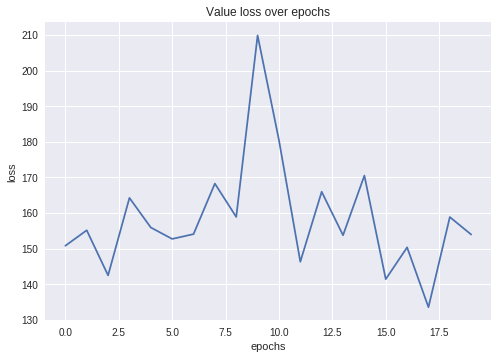

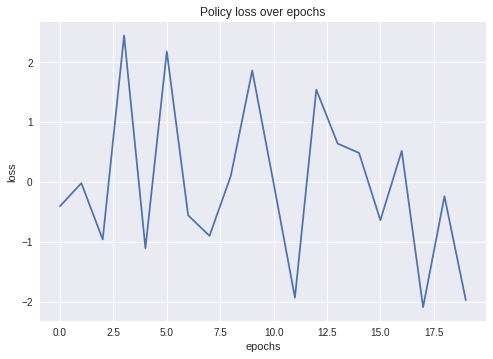

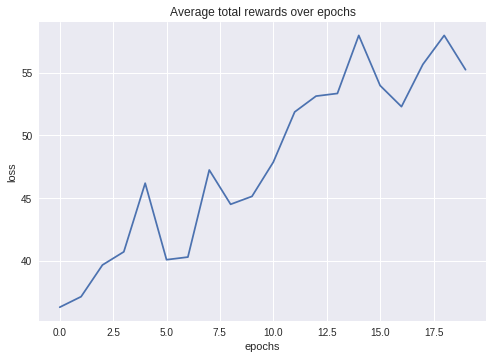

In [ ]:
fig = plt.figure()
plt.plot(avl_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Value loss over epochs")
plt.show()

plt.plot(apl_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Policy loss over epochs")
plt.show()

plt.plot(ar_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Average total rewards over epochs")
plt.show()



# Demonstration of a sample run using the trained network
​
Can't view the animation when exported as .ipynb, but we can still see the total reward gained

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
env = gym.make('Assault-v0')
state = env.reset()
frames = []
total_rewards = 0
for t in range(100):
    frames.append(env.render(mode='rgb_array'))
    state = torch.tensor(state).cuda(async=True).view(3, 250, 160).float()
    params, actions = policy(state.unsqueeze(0))
    action = actions[0]
    state, reward, done, info = env.step(action)
    total_rewards += reward
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
print("Total reward gained", total_rewards)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Total reward gained 63.0


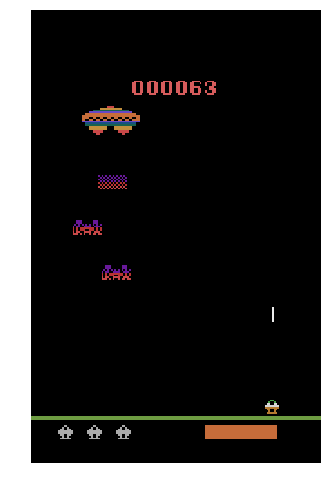

In [ ]:
animate_frames(frames, scale=30)